In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
plt.style.use('ggplot')
from assemble import DataStream, DataDescribe, Category, DataCleaner
import warnings
import json
warnings.filterwarnings('ignore')

In [2]:
train, test, all_data  = DataStream.load_data("data.json", "2-12Update")

In [3]:
X_train, X_test, y = DataStream.prepare_for_learn(train, all_data, "SalePrice")

In [4]:
print(X_train.shape)
print(X_test.shape)
print(y.shape)

(1460, 122)
(1459, 122)
(1460,)


In [5]:
y = np.log1p(y)

In [6]:
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error

def rmsle(y, y_pred):
     return np.sqrt((( (np.log1p(y_pred*price_scale)- np.log1p(y*price_scale)) )**2).mean())

# scorer = make_scorer(rmsle, False)
scorer = make_scorer(mean_squared_error, False)

def rmse_cv(model, X, y):
     return (cross_val_score(model, X, y, scoring=scorer)).mean()

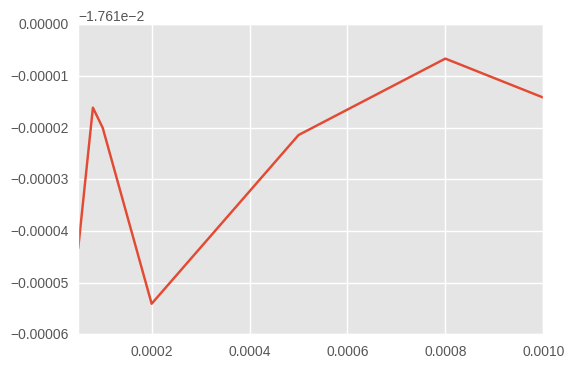

In [7]:
from sklearn.linear_model import Lasso
alphas = [5e-5, 8e-5, 1e-4,2e-4,  5e-4,8e-4, 1e-3]
cv_lasso = [rmse_cv(Lasso(alpha = alpha, max_iter=50000), X_train, y) for alpha in alphas]
pd.Series(cv_lasso, index = alphas).plot()

In [ ]:
model = Lasso(alpha = 8e-4, max_iter =  50000).fit(X_train, y)

In [ ]:
coef = pd.Series(model.coef_, index = X_train.columns).sort_values()
imp_coef = pd.concat([coef.head(10), coef.tail(10)])
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Model")

In [ ]:
p_pred = np.expm1(model.predict(X_train))
plt.scatter(p_pred, np.expm1(y))
plt.plot([min(p_pred),max(p_pred)], [min(p_pred),max(p_pred)], c="red")